# ARIMA

## 1. Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tools.eval_measures import rmse
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# mengganti tema plot menjadi dark
import os
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline

## 2. Data

In [2]:
data = pd.read_csv('manyung.csv', index_col='Produksi Hasil Tangkap Laut', parse_dates=True)
data.index.freq = 'MS'
data

,Manyung
Produksi Hasil Tangkap Laut,
2017-01-01,8.42
2017-02-01,8.43
2017-03-01,8.59
2017-04-01,8.48
2017-05-01,8.56
2017-06-01,8.52
2017-07-01,9.44
2017-08-01,9.95
2017-09-01,10.11


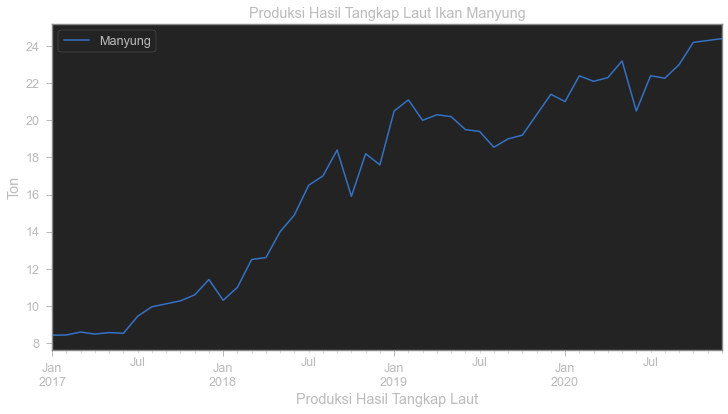

In [3]:
# PLOT
data.plot(figsize=(12,6), title='Produksi Hasil Tangkap Laut Ikan Manyung', ylabel='Ton');

## 3. Check Stationarity Data

In [4]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

# try in our data
adfuller_test(data['Manyung'])

Augmented Dickey-Fuller Test:
ADF test statistic      -0.715773
p-value                  0.842622
# lags used              1.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data is NON-stationary! Lakukan differencing

## 4. Differencing

In [5]:
data['Manyung d1'] = diff(data['Manyung'], k_diff=1)     #lag 1
# cek stationarity again
adfuller_test(data['Manyung d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -9.988531e+00
p-value                 2.024972e-17
# lags used             0.000000e+00
# observations          4.600000e+01
critical value (1%)    -3.581258e+00
critical value (5%)    -2.926785e+00
critical value (10%)   -2.601541e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data is STATIONARY!

Karena dilakukan differencing, modelnya adalah ARIMA/SARIMA

## 5. Check Seasonality Data

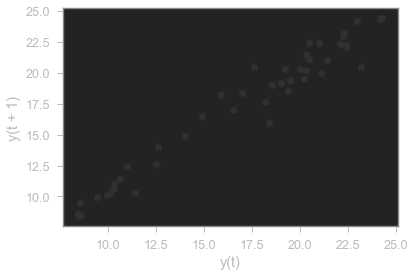

In [6]:
# With lag plot
lag_plot(data['Manyung']);

terlihat trend naik tetapi seasonality tidak diketahui

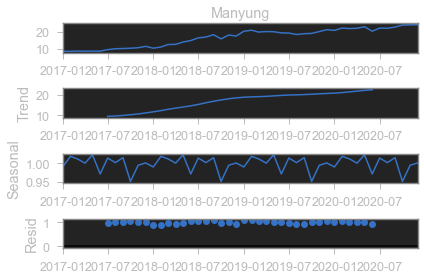

In [7]:
# With ETS (Error, Trend, Seasonality)
result = seasonal_decompose(data['Manyung'].dropna(), model='multiplicative')  # model='add' for linear
result.plot();

dari data asli, keliatan seperti exponential, maka model yg digunakan adalah multiplicative/mul.

terlihat untuk trend itu berada di interval 10-20 (10 range), sedangkan seasonal hanya berada di interval 0.95-1.00 (0.05 range), dimana nilai tsb sangat kecil untuk menyatakan terdapat seasonality pada data. maka dapat dikatakan data tidak memiliki seasonality

## 6. Find (p,d,q)ARIMA Model

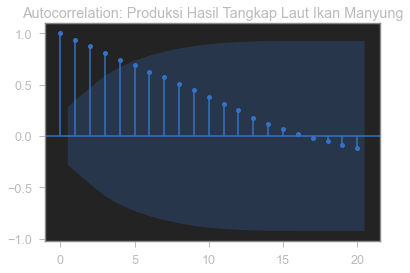

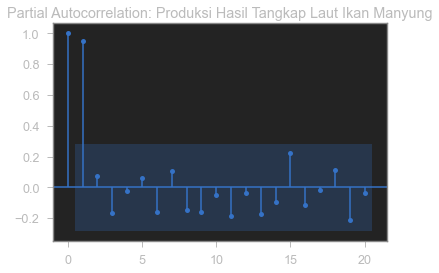

In [8]:
# Plot ACF
lags = 20
title = 'Autocorrelation: Produksi Hasil Tangkap Laut Ikan Manyung'
plot_acf(data['Manyung'],title=title,lags=lags);
# PLOT PACF
lags = 20
title = 'Partial Autocorrelation: Produksi Hasil Tangkap Laut Ikan Manyung'
plot_pacf(data['Manyung'],title=title,lags=lags);

In [9]:
# autoarima
auto_arima(data['Manyung'], seasonal=False, stationary=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=140.199, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=134.709, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=136.629, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=143.056, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=136.052, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=136.304, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=138.004, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=142.102, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.485 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

> <em>If the PACF of a differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive, while the ACF decays more slowly--then consider adding an **AR** terms to the model. Meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. The lag at which the PACF cuts off is indicated number of AR terms.</em><br>

Karena terjadi hal tsb, maka gunakan AR(1) dan MA(0)/MA(1). Untuk MA, lihat yg memiliki less error. Ternyata ARIMA(1,1,0)/MA(0) memiliki less error, dan auto_arima merekomendasikan model yg sama. Maka gunakan ARIMA(1,1,0)

## 7. Split Data

In [10]:
# Ingin memprediksi 6 bulan berikutnya
train_data = data['Manyung'].iloc[:-6]
test_data = data['Manyung'].iloc[-6:]

train_data, test_data

(Produksi Hasil Tangkap Laut
 2017-01-01     8.42
 2017-02-01     8.43
 2017-03-01     8.59
 2017-04-01     8.48
 2017-05-01     8.56
 2017-06-01     8.52
 2017-07-01     9.44
 2017-08-01     9.95
 2017-09-01    10.11
 2017-10-01    10.27
 2017-11-01    10.59
 2017-12-01    11.42
 2018-01-01    10.30
 2018-02-01    11.00
 2018-03-01    12.50
 2018-04-01    12.60
 2018-05-01    14.00
 2018-06-01    14.90
 2018-07-01    16.50
 2018-08-01    17.00
 2018-09-01    18.40
 2018-10-01    15.90
 2018-11-01    18.20
 2018-12-01    17.60
 2019-01-01    20.50
 2019-02-01    21.10
 2019-03-01    20.00
 2019-04-01    20.30
 2019-05-01    20.20
 2019-06-01    19.50
 2019-07-01    19.40
 2019-08-01    18.55
 2019-09-01    19.00
 2019-10-01    19.20
 2019-11-01    20.30
 2019-12-01    21.40
 2020-01-01    21.01
 2020-02-01    22.40
 2020-03-01    22.10
 2020-04-01    22.30
 2020-05-01    23.20
 2020-06-01    20.50
 Freq: MS, Name: Manyung, dtype: float64,
 Produksi Hasil Tangkap Laut
 2020-07-01    22.

## 8. ARIMA Train Model

ARIMA(1,1,0)

In [11]:
# model ARIMA in train data
model_train_ARIMA = ARIMA(train_data, order=(1,1,0)).fit()
model_train_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Manyung   No. Observations:                   41
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -58.256
Method:                       css-mle   S.D. of innovations              1.000
Date:                Sun, 12 Dec 2021   AIC                            122.512
Time:                        20:28:12   BIC                            127.653
Sample:                    02-01-2017   HQIC                           124.384
                         - 06-01-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3162      0.116      2.735      0.006       0.090       0.543
ar.L1.D.Manyung    -0.3624      0.162     -2.243      0.025      -0.679      -0.046
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7594           +0.0000j            2.7594            0.5000
-----------------------------------------------------------------------------
"""

## 9. Test Prediction

In [12]:
prediction_test = model_train_ARIMA.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Prediction')
prediction_test

2020-07-01    21.909252
2020-08-01    21.829317
2020-09-01    22.289061
2020-10-01    22.553226
2020-11-01    22.888268
2020-12-01    23.197625
Freq: MS, Name: ARIMA(1,1,0) Prediction, dtype: float64

Digunakan typ='levels' krn ingin melihat hasil prediksi dari data asli, bukan data yg sudah didifferencing

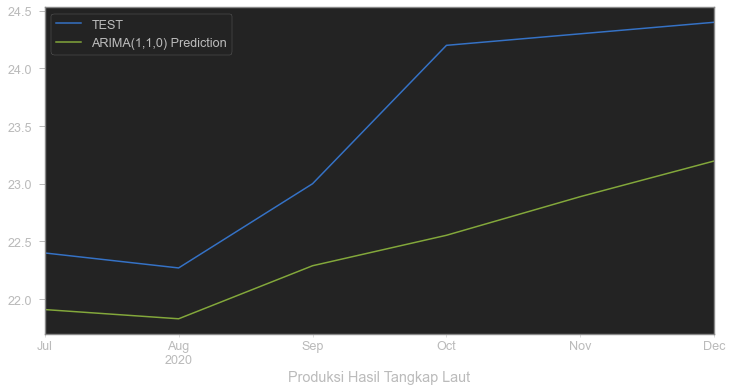

In [13]:
# PLOT
test_data.plot(legend=True, label='TEST')
prediction_test.plot(legend=True, figsize=(12,6));

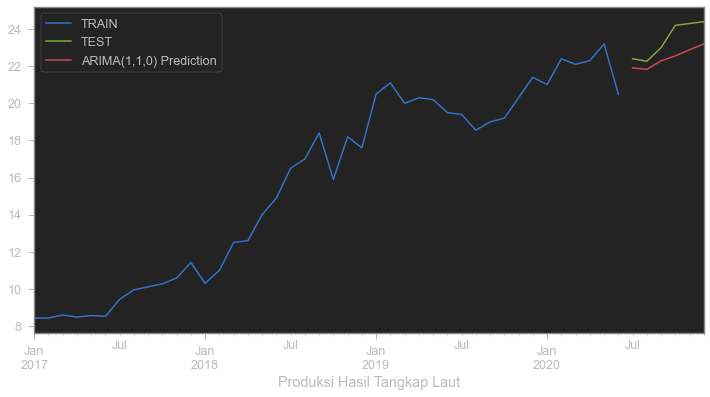

In [14]:
# PLOT
train_data.plot(legend=True, label='TRAIN')
test_data.plot(legend=True, label='TEST')
prediction_test.plot(legend=True, figsize=(12,6));

## 10. Evaluate Model

In [15]:
print('Mean Train data -->', train_data.mean())
print('Standard Deviation Train data -->', train_data.std())
print('\n')

error = rmse(test_data, prediction_test)
print(f'ARIMA(1,1,0) RMSE Error: {error:11.10}')
aic_values = model_train_ARIMA.aic
print(f'ARIMA(1,1,0) AIC: {aic_values:6.5}')
print('\n')

print('Mean Test data -->', test_data.mean())
print('Mean Prediction results -->', prediction_test.mean())

Mean Train data --> 15.777142857142858
Standard Deviation Train data --> 5.047134074832764


ARIMA(1,1,0) RMSE Error: 1.087123761
ARIMA(1,1,0) AIC: 122.51


Mean Test data --> 23.42833333333333
Mean Prediction results --> 22.44445799472329


Rata-rata train data itu 15, prediksinya menyimpang 1.08 (RMSE). Standar deviasi (statistik yang mengukur penyebaran kumpulan data relatif terhadap rata-rata) train data itu 5,  prediksinya menyimpang 1.08 (RMSE). Artinya error tidak menyimpang terhadap statistik data. Sehingga this is not bad prediction. Bisa dilihat juga Mean prediction results hampir mirip dgn mean test data.

## 11. Re-Fit Model to Entire Dataset

In [16]:
model_ARIMA = ARIMA(data['Manyung'], order=(1,1,0)).fit()
model_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Manyung   No. Observations:                   47
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -64.354
Method:                       css-mle   S.D. of innovations              0.950
Date:                Sun, 12 Dec 2021   AIC                            134.709
Time:                        20:28:13   BIC                            140.259
Sample:                    02-01-2017   HQIC                           136.797
                         - 12-01-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3434      0.101      3.400      0.001       0.145       0.541
ar.L1.D.Manyung    -0.3802      0.133     -2.862      0.004      -0.641      -0.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6303           +0.0000j            2.6303            0.5000
-----------------------------------------------------------------------------
"""

## 12. Forecasting The Future

In [17]:
# forecasting the next 6 months
forecast = model_ARIMA.predict(start=len(data), end=len(data)+5, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Forecast')
forecast

2021-01-01    24.835909
2021-02-01    25.144112
2021-03-01    25.500866
2021-04-01    25.839162
2021-05-01    26.184475
2021-06-01    26.527120
Freq: MS, Name: ARIMA(1,1,0) Forecast, dtype: float64

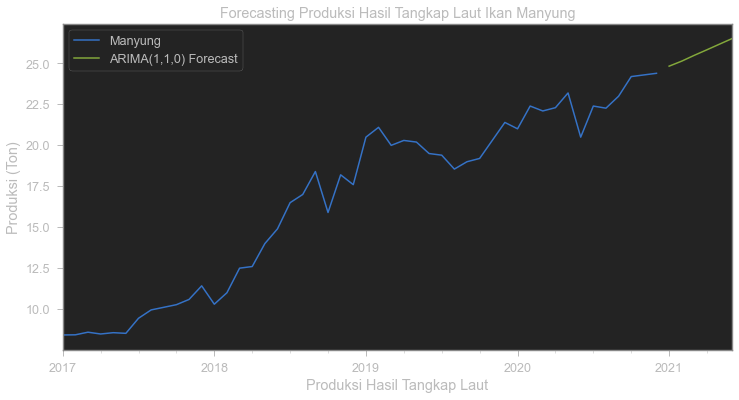

In [18]:
# PLOT
data['Manyung'].plot(legend=True)
forecast.plot(figsize=(12,6), legend=True, title='Forecasting Produksi Hasil Tangkap Laut Ikan Manyung', ylabel='Produksi (Ton)');

In [19]:
# save model
model_ARIMA.save('model_manyung.pkl')